In [1]:
from neuron_circuit import *

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

In [3]:
"""
    "Ro": 32,
    "Bt": 2.6666666666666665,
    "P": 10
"""
"""
    "Ro": 1,
    "Bt": 2,
    "P": 1
"""

'\n    "Ro": 1,\n    "Bt": 2,\n    "P": 1\n'

In [4]:
try:
    with open('config.json', 'r') as f:
        config = json.load(f)
    print("Arquivo de configuração 'config.json' carregado com sucesso.")
except FileNotFoundError:
    print("Erro: O arquivo 'config.json' não foi encontrado. Certifique-se de que ele está na mesma pasta.")
    # Se o arquivo não existir, paramos a execução nesta célula
    raise

# --- 2. EXTRAIR OS PARÂMETROS DO ARQUIVO DE CONFIGURAÇÃO ---
print("\nExtraindo parâmetros:")
# Parâmetros da simulação
number_of_layers = config['simulation_params']['number_of_layers']
dt = config['simulation_params']['dt']
mode = config['simulation_params']['mode']
print(f" - number_of_layers: {number_of_layers}, dt: {dt}, mode: '{mode}'")

# Configuração do circuito
num_qubits = config['circuit_setup']['num_qubits']
num_clbits = config['circuit_setup']['num_clbits']
inputs = config['circuit_setup']['inputs']
print(f" - num_qubits: {num_qubits}, inputs: {inputs}")

# Parâmetros do atrator de Lorenz
Ro = config['lorenz_params']['Ro']
Bt = config['lorenz_params']['Bt']
P = config['lorenz_params']['P']
print(f" - Lorenz params (Ro, Bt, P): {Ro}, {Bt}, {P}")

# Parâmetros de normalização
edge_factor = config['normalization_params']['edge_factor']

# --- 3. PROCESSAR OS TEMPLATES A PARTIR DO JSON ---
# Carrega os templates como estão no arquivo
feedback_template = config['templates']['feedback_template']
control_template_str = config['templates']['control_template_lorenz']

# Cria um mapa para substituir as strings "1-P", "P", etc., pelos seus valores numéricos
param_map = {
    "P": P,
    "Ro": Ro,
    "1-P": 1 - P,
    "1-Bt": 1 - Bt
}

# Constrói o control_template final, trocando as strings pelos valores
control_template = [
    [param_map.get(item, item) for item in row] for row in control_template_str
]
print("\nTemplates processados a partir do JSON.")

apply_unwrap = config['visualization_params']['apply_unwrap']
print(f"\nUnwrap: {apply_unwrap}")

Arquivo de configuração 'config.json' carregado com sucesso.

Extraindo parâmetros:
 - number_of_layers: 500, dt: 0.025, mode: 'non-hybrid'
 - num_qubits: 3, inputs: [1, 0, -1]
 - Lorenz params (Ro, Bt, P): 32, 2.6666666666666665, 10

Templates processados a partir do JSON.

Unwrap: True


In [5]:
def normalize_proportional(control_template, feedback_template, edge_factor=1.0):

    all_values = np.concatenate([np.ravel(control_template), np.ravel(feedback_template)])

    global_max_abs = np.max(np.abs(all_values))

    if global_max_abs == 0:
        return np.array(control_template, dtype=float), np.array(feedback_template, dtype=float)

    scale_factor = edge_factor * np.pi / global_max_abs

    normalized_control = np.array(control_template) * scale_factor
    normalized_feedback = np.array(feedback_template) * scale_factor

    return normalized_control, normalized_feedback

def normalize_proportional(control_template, feedback_template, inputs, edge_factor=1.0):

    inputs_np = np.array(inputs, dtype=float)

    all_values = np.concatenate([
        np.ravel(control_template), 
        np.ravel(feedback_template), 
        np.ravel(inputs_np)
    ])

    global_max_abs = np.max(np.abs(all_values))

    if global_max_abs == 0:
        scale_factor = 1.0
    else:
        scale_factor = edge_factor * np.pi / global_max_abs

    normalized_control = np.array(control_template, dtype=float) * scale_factor
    normalized_feedback = np.array(feedback_template, dtype=float) * scale_factor
    normalized_inputs = inputs_np * scale_factor / np.pi

    return normalized_control, normalized_feedback, normalized_inputs

In [6]:
# Inicializa o circuito quântico com os parâmetros do JSON
qc = neuron_circuit(num_qubits, num_clbits)

# Normaliza os templates que foram carregados e processados
"""control_template, feedback_template = normalize_proportional(
    control_template, 
    feedback_template,
    edge_factor=edge_factor
)"""
control_template, feedback_template, inputs_normalized = normalize_proportional(
    control_template, 
    feedback_template,
    inputs,
    edge_factor=edge_factor
)

C:\Users\pedro\AppData\Local\Temp\ipykernel_38284\1577513826.py:2: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  qc = neuron_circuit(num_qubits, num_clbits)
C:\Users\pedro\AppData\Local\Temp\ipykernel_38284\1577513826.py:2: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  qc = neuron_circuit(num_qubits, num_clbits)


In [7]:
results = qc.evaluate_observable_evolution(
    inputs=inputs_normalized,
    inputs_normalized=inputs_normalized,
    control_template=control_template,
    feedback_template=feedback_template,
    total_layers=number_of_layers,
    mode=mode,
    dt=dt
)

In [8]:
qc.print_current_circuit(output='latex_source')

C:\Users\pedro\AppData\Roaming\Python\Python313\site-packages\qiskit\visualization\circuit\latex.py:155: UserWarning: Style JSON file 'ascii.json' not found in any of these locations: C:\Users\pedro\AppData\Roaming\Python\Python313\site-packages\qiskit\visualization\circuit\styles\ascii.json, ascii.json. Will use default style.
  self._style, _ = load_style(


\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \gate{\mathrm{R_Y}\,(\mathrm{1.54})} & \gate{\mathrm{R_X}\,(\mathrm{-9.112e-05})} \barrier[0em]{2} & \qw & \ctrl{1} & \ctrl{2} & \gate{\mathrm{R_Y}\,(\mathrm{0})} & \gate{\mathrm{R_Y}\,(\mathrm{-0.0009719})} & \qw & \qw & \gate{\mathrm{R_Y}\,(\mathrm{0.0009719})} & \qw & \qw \barrier[0em]{2} & \qw & \qw & \targ & \ctrl{1} & \targ & \ctrl{1} & \qw & \targ & \ctrl{2} & \targ & \ctrl{2} \barrier[0em]{2} & \qw & \gate{\mathrm{R_X}\,(\mathrm{-9.112e-05})} \barrier[0em]{2} & \qw & \ctrl{1} & \ctrl{2} & \gate{\mathrm{R_Y}\,(\mathrm{0})} & \gate{\mathrm{R_Y}\,(\mathrm{-0.0009719})} & \qw & \qw & \gate{\mathrm{R_Y}\,(\mathrm{0.0009719})} & \qw & \qw \barrier[0em]{2} & \qw & \qw & \targ & \ctrl{1} & \targ & \ctrl{1} & \qw & \targ & \ctrl{2} & \targ & \ctrl{2} \barrier[0em]{2} & \qw &

In [9]:
def unwrap_reflected_data(data: np.ndarray) -> np.ndarray:
    """
    Desdobra dados que foram refletidos nos limites -1 e 1 usando extrapolação
    linear para prever o próximo ponto e resolver ambiguidades nas reflexões.
    Esta é a versão definitiva e robusta.

    Args:
        data: Um array NumPy 1D com os dados limitados entre -1 e 1.

    Returns:
        Um array NumPy 1D com os dados desdobrados em um espaço contínuo.
    """
    if len(data) < 2:
        return np.array(data, dtype=float)

    unwrapped = np.zeros_like(data, dtype=float)
    unwrapped[0] = data[0]

    # --- Trata o segundo ponto (índice 1) ---
    # Como não temos direção, escolhemos o candidato mais próximo ao primeiro ponto.
    y_prev = unwrapped[0]
    x_curr = data[1]
    
    offset = round((y_prev - x_curr) / 4.0) * 4.0
    candidates = [
        x_curr + offset,       # Rampa y = x
        2.0 - x_curr + offset,  # Rampa y = 2 - x
        -2.0 - x_curr + offset, # Rampa y = -2 - x
    ]
    diffs = np.abs(np.array(candidates) - y_prev)
    unwrapped[1] = candidates[np.argmin(diffs)]
    
    # --- Itera sobre o resto dos pontos (a partir do índice 2) ---
    for i in range(2, len(data)):
        y_prev = unwrapped[i-1]
        y_prev2 = unwrapped[i-2]
        x_curr = data[i]

        # 1. Extrapola para prever onde o próximo ponto deveria estar
        velocity = y_prev - y_prev2
        y_predicted = y_prev + velocity

        # 2. Gera os possíveis candidatos para o valor real
        offset = round((y_predicted - x_curr) / 4.0) * 4.0
        candidates = []
        # Gera candidatos nos ciclos adjacentes para garantir robustez
        for k_offset in [-4.0, 0.0, 4.0]:
            candidates.append(x_curr + offset + k_offset)
            candidates.append(2.0 - x_curr + offset + k_offset)
            candidates.append(-2.0 - x_curr + offset + k_offset)

        # 3. Escolhe o candidato mais próximo do PONTO PREVISTO
        diffs = np.abs(np.array(candidates) - y_predicted)
        best_candidate_idx = np.argmin(diffs)
        unwrapped[i] = candidates[best_candidate_idx]

    return unwrapped
    """
    Desdobra dados que foram refletidos nos limites -1 e 1 usando uma
    extrapolação linear mais robusta, baseada em uma média móvel da velocidade
    para mitigar o efeito de ruído.

    Args:
        data: Um array NumPy 1D com os dados limitados entre -1 e 1.
        smoothing_window: O número de pontos anteriores a serem usados para
                          calcular a velocidade média. Um valor maior oferece
                          mais suavização, mas menos responsividade a
                          mudanças rápidas de direção.

    Returns:
        Um array NumPy 1D com os dados desdobrados em um espaço contínuo.
    """

def unwrap_reflected_data(data: np.ndarray, smoothing_window: int = 2) -> np.ndarray:

    if len(data) < smoothing_window + 1:
        # Se não houver pontos suficientes, recorra à função original ou a uma
        # abordagem mais simples. Por simplicidade, retornamos os dados como estão.
        print(f"Aviso: Comprimento dos dados ({len(data)}) é menor que a janela de suavização + 1 ({smoothing_window + 1}).")
        return np.array(data, dtype=float)

    unwrapped = np.zeros_like(data, dtype=float)
    unwrapped[:smoothing_window] = data[:smoothing_window] # Inicializa os primeiros pontos

    # --- Itera sobre o resto dos pontos ---
    for i in range(smoothing_window, len(data)):
        # --- 1. Previsão Robusta ---
        # Calcula a velocidade média sobre a janela de suavização
        # Usamos os últimos 'smoothing_window' pontos JÁ DESDOBRADOS para a previsão
        velocities = np.diff(unwrapped[i-smoothing_window : i])
        avg_velocity = np.mean(velocities)
        
        y_prev = unwrapped[i-1]
        y_predicted = y_prev + avg_velocity # Previsão baseada na tendência

        # --- 2. Geração de Candidatos (lógica original, que é excelente) ---
        x_curr = data[i]
        offset = round((y_predicted - x_curr) / 4.0) * 4.0
        candidates = []
        # Gera candidatos nos ciclos adjacentes para garantir robustez
        for k_offset in [-4.0, 0.0, 4.0]:
            candidates.append(x_curr + offset + k_offset)        # y = x
            candidates.append(2.0 - x_curr + offset + k_offset)  # y = 2 - x (reflexão em +1)
            candidates.append(-2.0 - x_curr + offset + k_offset) # y = -2 - x (reflexão em -1)

        # --- 3. Seleção do Melhor Candidato ---
        # Escolhe o candidato mais próximo do PONTO PREVISTO
        diffs = np.abs(np.array(candidates) - y_predicted)
        best_candidate_idx = np.argmin(diffs)
        unwrapped[i] = candidates[best_candidate_idx]

    return unwrapped

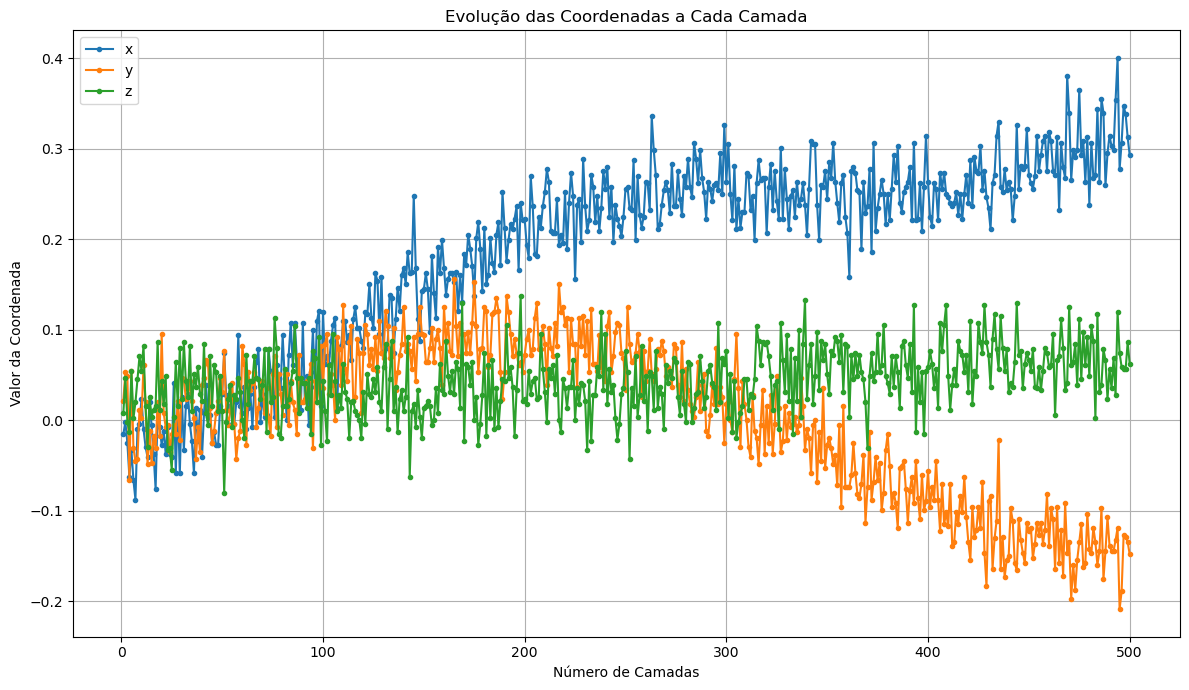

In [10]:
layer_range = range(1, number_of_layers + 1)

plt.figure(figsize=(12, 7))
for label, values in results.items():
    plt.plot(layer_range, values, marker='.', linestyle='-', label=label)

plt.xlabel('Número de Camadas')
plt.ylabel('Valor da Coordenada')
plt.title('Evolução das Coordenadas a Cada Camada')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
dic_labels = {'<Z_0>': 'x', '<Z_1>': 'y', '<Z_2>': 'z'}
"""if apply_unwrap:
    unwrapped_results = {}
    reflection_points = {}
    layer_range = range(1, number_of_layers + 1)

    print("Processando e identificando pontos de dereflexão...")
    for qubit in range(3):
        qubit_label = dic_labels[f'<Z_{qubit}>']
        original_data = results[qubit_label]

        # Use a versão robusta da função para melhores resultados
        unwrapped_data = unwrap_reflected_data(original_data, smoothing_window=3)
        unwrapped_results[qubit_label] = unwrapped_data

        # Encontra os índices onde uma dereflexão ocorreu
        reflection_indices = []
        for i in range(1, len(unwrapped_data)):
            # Uma dereflexão ocorre quando cruzamos uma fronteira (..., -1, 1, 3, ...)
            # Podemos checar isso vendo se o "piso" da zona muda.
            prev_zone = np.floor((unwrapped_data[i-1] + 1) / 2)
            curr_zone = np.floor((unwrapped_data[i] + 1) / 2)
            if prev_zone != curr_zone:
                reflection_indices.append(i)
        
        reflection_points[qubit] = reflection_indices
        print(f"Qubit {qubit}: Encontrados {len(reflection_indices)} pontos de dereflexão.")

    # 2. Plotagem Comparativa
    plt.figure(figsize=(15, 8)) # Aumentei o tamanho para melhor visualização
    
    # Cores padrão do matplotlib para consistência
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for qubit in range(3):
        qubit_label = dic_labels[f'<Z_{qubit}>']
        color = colors[qubit % len(colors)]
        
        original_values = results[qubit_label]
        unwrapped_values = unwrapped_results[qubit_label]

        # Plota a curva original (tracejada, semi-transparente)
        plt.plot(layer_range, original_values, color=color, linestyle='--', alpha=0.7, label=f'{qubit_label} Original')

        # Plota a curva nova "derefletida" (sólida, com marcadores)
        plt.plot(layer_range, unwrapped_values, color=color, linestyle='-', marker='.', markersize=5, label=f'{qubit_label} Derefletido')
        
        # Destaca os pontos de dereflexão com círculos vermelhos
        ref_indices = reflection_points[qubit]
        if ref_indices: # Apenas plota se houver pontos
            ref_layers = [layer_range[i] for i in ref_indices]
            ref_values = [unwrapped_values[i] for i in ref_indices]
            
            # Adiciona a label apenas para o primeiro qubit para não poluir a legenda
            ref_label = 'Ponto de Dereflexão' if qubit == 0 else None
            plt.scatter(ref_layers, ref_values, s=100, facecolors='none', edgecolors='red', linewidths=1.5, zorder=5, label=ref_label)

    plt.xlabel('Número de Camadas')
    plt.ylabel('Valor Esperado <Z>')
    plt.title('Comparação: Original vs. Derefletido com Pontos de Transição')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()"""

'if apply_unwrap:\n    unwrapped_results = {}\n    reflection_points = {}\n    layer_range = range(1, number_of_layers + 1)\n\n    print("Processando e identificando pontos de dereflexão...")\n    for qubit in range(3):\n        qubit_label = dic_labels[f\'<Z_{qubit}>\']\n        original_data = results[qubit_label]\n\n        # Use a versão robusta da função para melhores resultados\n        unwrapped_data = unwrap_reflected_data(original_data, smoothing_window=3)\n        unwrapped_results[qubit_label] = unwrapped_data\n\n        # Encontra os índices onde uma dereflexão ocorreu\n        reflection_indices = []\n        for i in range(1, len(unwrapped_data)):\n            # Uma dereflexão ocorre quando cruzamos uma fronteira (..., -1, 1, 3, ...)\n            # Podemos checar isso vendo se o "piso" da zona muda.\n            prev_zone = np.floor((unwrapped_data[i-1] + 1) / 2)\n            curr_zone = np.floor((unwrapped_data[i] + 1) / 2)\n            if prev_zone != curr_zone:\n      

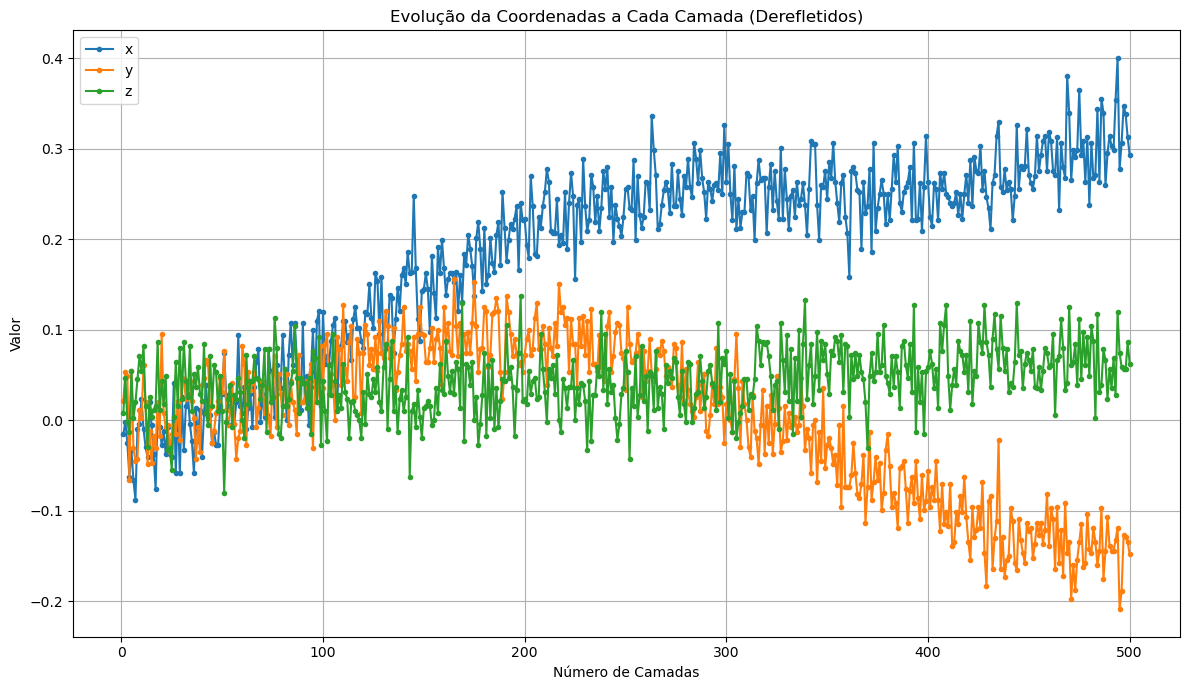

In [12]:
new_results = {}
if apply_unwrap:
    for qubit in range(3):
        new_results[dic_labels[f'<Z_{qubit}>']] = unwrap_reflected_data(results[dic_labels[f'<Z_{qubit}>']], smoothing_window=3)


    layer_range = range(1, number_of_layers + 1)
    plt.figure(figsize=(12, 7))
    for label, values in new_results.items():
        plt.plot(layer_range, values, marker='.', linestyle='-', label=label)

    plt.xlabel('Número de Camadas')
    plt.ylabel('Valor')
    plt.title('Evolução da Coordenadas a Cada Camada (Derefletidos)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [13]:
print("--- Escolha a Visualização ---")
print("1: Gráfico com Trajetória")
print("2: Gráfico com Setas (Direção da Trajetória)")
print("3: Gráfico Interativo")

#plot_choice = input("Digite o número do gráfico desejado (1-3): ")
plot_choice = '3'

x_coords = new_results[dic_labels['<Z_0>']]
y_coords = new_results[dic_labels['<Z_1>']]
z_coords = new_results[dic_labels['<Z_2>']]

camadas = list(range(1, number_of_layers + 1)) 

# GRÁFICO 1
if plot_choice == '1':
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x_coords, y_coords, z_coords, color='gray', alpha=0.6, linestyle='--')
    plot = ax.scatter(x_coords, y_coords, z_coords, c=camadas, cmap='viridis', marker='o')
    cbar = fig.colorbar(plot, ax=ax, shrink=0.7)
    cbar.set_label('Número de Camadas')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title(f'Trajetória do Estado do Sistema')
    plt.tight_layout()
    plt.show()

# GRÁFICO 2
elif plot_choice == '2':
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    plot = ax.scatter(x_coords, y_coords, z_coords, c=camadas, cmap='viridis', s=50, depthshade=True)
    for i in range(number_of_layers - 1):
        ax.quiver(
            x_coords[i], y_coords[i], z_coords[i],
            x_coords[i+1] - x_coords[i],
            y_coords[i+1] - y_coords[i],
            z_coords[i+1] - z_coords[i],
            arrow_length_ratio=0.3, color='gray', alpha=0.7
        )
    cbar = fig.colorbar(plot, ax=ax, shrink=0.7)
    cbar.set_label('Número de Camadas')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title(f'Trajetória com Direção')
    ax.view_init(elev=25, azim=-135)
    plt.tight_layout()
    plt.show()

# GRÁFICO 3
elif plot_choice == '3':
    fig = go.Figure(data=[
        go.Scatter3d(
            x=x_coords, y=y_coords, z=z_coords,
            mode='lines+markers',
            marker=dict(
                size=6, color=camadas, colorscale='Viridis',
                colorbar_title='Número de Camadas', showscale=True
            ),
            line=dict(color='darkgrey', width=2)
        )
    ])
    fig.update_layout(
        title=f'Trajetória Interativa do Sistema',
        scene=dict(
            xaxis_title='x', yaxis_title='y', zaxis_title='z',
            aspectratio=dict(x=1, y=1, z=1)
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )
    fig.show()

--- Escolha a Visualização ---
1: Gráfico com Trajetória
2: Gráfico com Setas (Direção da Trajetória)
3: Gráfico Interativo
